# About this Notebook

Bayesian temporal matrix factorization is a type of Bayesian matrix factorization that achieves state-of-the-art results on challenging imputation and prediction problems. In the following, we will discuss:

- What the proposed Bayesian temporal matrix factorization (BTMF for short) is?

- How to implement BTMF mainly using Python `Numpy` with high efficiency?

- How to develop a spatiotemporal prediction model by adapting BTMF?

- How to make predictions with real-world spatiotemporal datasets?


In [1]:
import numpy as np
from numpy import linalg as LA
from numpy.random import multivariate_normal
from scipy.stats import wishart

def Normal_Wishart(mu_0, lamb, W, nu, seed = None):
    """Function drawing a Gaussian-Wishart random variable"""
    Lambda = wishart(df = nu, scale = W, seed = seed).rvs()
    cov = np.linalg.inv(lamb * Lambda)
    mu = multivariate_normal(mu_0, cov)
    return mu, Lambda

# Matrix Computation Concepts

## Kronecker product

- **Definition**:

Given two matrices $A\in\mathbb{R}^{m_1\times n_1}$ and $B\in\mathbb{R}^{m_2\times n_2}$, then, the **Kronecker product** between these two matrices is defined as

$$A\otimes B=\left[ \begin{array}{cccc} a_{11}B & a_{12}B & \cdots & a_{1m_2}B \\ a_{21}B & a_{22}B & \cdots & a_{2m_2}B \\ \vdots & \vdots & \ddots & \vdots \\ a_{m_11}B & a_{m_12}B & \cdots & a_{m_1m_2}B \\ \end{array} \right]$$
where the symbol $\otimes$ denotes Kronecker product, and the size of resulted $A\otimes B$ is $(m_1m_2)\times (n_1n_2)$ (i.e., $m_1\times m_2$ columns and $n_1\times n_2$ rows).

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]$ and $B=\left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10 \\ \end{array} \right]$, then, we have

$$A\otimes B=\left[ \begin{array}{cc} 1\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 2\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ 3\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] & 4\times \left[ \begin{array}{ccc} 5 & 6 & 7\\ 8 & 9 & 10\\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cccccc} 5 & 6 & 7 & 10 & 12 & 14 \\ 8 & 9 & 10 & 16 & 18 & 20 \\ 15 & 18 & 21 & 20 & 24 & 28 \\ 24 & 27 & 30 & 32 & 36 & 40 \\ \end{array} \right]\in\mathbb{R}^{4\times 6}.$$

## Khatri-Rao product (`kr_prod`)

- **Definition**:

Given two matrices $A=\left( \boldsymbol{a}_1,\boldsymbol{a}_2,...,\boldsymbol{a}_r \right)\in\mathbb{R}^{m\times r}$ and $B=\left( \boldsymbol{b}_1,\boldsymbol{b}_2,...,\boldsymbol{b}_r \right)\in\mathbb{R}^{n\times r}$ with same number of columns, then, the **Khatri-Rao product** (or **column-wise Kronecker product**) between $A$ and $B$ is given as follows,

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2,...,\boldsymbol{a}_r\otimes \boldsymbol{b}_r \right)\in\mathbb{R}^{(mn)\times r}$$
where the symbol $\odot$ denotes Khatri-Rao product, and $\otimes$ denotes Kronecker product.

- **Example**:

If $A=\left[ \begin{array}{cc} 1 & 2 \\ 3 & 4 \\ \end{array} \right]=\left( \boldsymbol{a}_1,\boldsymbol{a}_2 \right) $ and $B=\left[ \begin{array}{cc} 5 & 6 \\ 7 & 8 \\ 9 & 10 \\ \end{array} \right]=\left( \boldsymbol{b}_1,\boldsymbol{b}_2 \right) $, then, we have

$$A\odot B=\left( \boldsymbol{a}_1\otimes \boldsymbol{b}_1,\boldsymbol{a}_2\otimes \boldsymbol{b}_2 \right) $$

$$=\left[ \begin{array}{cc} \left[ \begin{array}{c} 1 \\ 3 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 5 \\ 7 \\ 9 \\ \end{array} \right] & \left[ \begin{array}{c} 2 \\ 4 \\ \end{array} \right]\otimes \left[ \begin{array}{c} 6 \\ 8 \\ 10 \\ \end{array} \right] \\ \end{array} \right]$$

$$=\left[ \begin{array}{cc} 5 & 12 \\ 7 & 16 \\ 9 & 20 \\ 15 & 24 \\ 21 & 32 \\ 27 & 40 \\ \end{array} \right]\in\mathbb{R}^{6\times 2}.$$

In [2]:
def kr_prod(a, b):
    return np.einsum('ir, jr -> ijr', a, b).reshape(a.shape[0] * b.shape[0], -1)

In [3]:
A = np.array([[1, 2], [3, 4]])
B = np.array([[5, 6], [7, 8], [9, 10]])
print(kr_prod(A, B))

[[ 5 12]
 [ 7 16]
 [ 9 20]
 [15 24]
 [21 32]
 [27 40]]


In [4]:
def BTMF(dense_mat, sparse_mat, W, X, theta, time_lags, maxiter1, maxiter2):
    """Bayesian Temporal Matrix Factorization, BTMF."""
    d=theta.shape[0]
    dim1 = sparse_mat.shape[0]
    dim2 = sparse_mat.shape[1]
    rank = W.shape[1]
    pos = np.where((dense_mat > 0) & (sparse_mat == 0))
    position = np.where(sparse_mat > 0)
    binary_mat = np.zeros((dim1, dim2))
    binary_mat[position] = 1
    
    tau = 1
    alpha = 1e-6
    beta = 1e-6
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    
    for iter in range(maxiter1):
        W_bar = np.mean(W, axis = 0)
        var_mu0 = (dim1 * W_bar + beta0 * mu0)/(dim1 + beta0)
        var_nu = dim1 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim1 * np.cov(W.T) + dim1 * beta0/(dim1 + beta0)
                             * np.outer(W_bar - mu0, W_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim1 + beta0, var_W, var_nu, seed = None)
        
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat.T).reshape([rank, rank, 
                                                            dim1]) + np.dstack([var_Lambda0] * dim1)
        var4 = tau * np.matmul(var1, sparse_mat.T) + np.dstack([np.matmul(var_Lambda0, 
                                                                          var_mu0)] * dim1)[0, :, :]
        for i in range(dim1):
            var_Lambda1 = var3[ :, :, i]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, i])
            W[i, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
        
        var_nu = dim2 + nu0
        mat0 = X[0 : np.max(time_lags), :]
        mat = np.matmul(mat0.T, mat0)
        new_mat = np.zeros((dim2 - np.max(time_lags), rank))
        for t in range(dim2 - np.max(time_lags)):
            new_mat[t, :] = X[t + np.max(time_lags), :] - np.einsum('ij, ij -> j', 
                                                                 theta, X[t + np.max(time_lags)
                                                                          - time_lags, :])
        mat += np.matmul(new_mat.T, new_mat)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat).reshape([rank, rank, 
                                                          dim2]) + np.dstack([Lambda_x] * dim2)
        var4 = tau * np.matmul(var1, sparse_mat)
        for t in range(dim2):
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t >= 0 and t <= np.max(time_lags) - 1:
                Qt = np.zeros(rank)
            else:
                Qt = np.matmul(Lambda_x, np.einsum('ij, ij -> j', theta, X[t - time_lags, :]))
            if t >= 0 and t <= dim2 - np.min(time_lags) - 1:
                if t > np.max(time_lags) - 1 and t <= dim2 - np.max(time_lags) - 1:
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags > np.max(time_lags) - 1) 
                                          & (t + time_lags <= dim2 - 1)))[0]
                for k in index:
                    Ak = theta[k, :]
                    Mt += np.multiply(np.outer(Ak, Ak), Lambda_x)
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    var5 = X[t + time_lags[k], :] - np.einsum('ij, ij -> j', 
                                                              theta0, X[t + time_lags[k] 
                                                                        - time_lags, :])
                    Nt += np.matmul(np.matmul(np.diag(Ak), Lambda_x), var5)
            var_mu = var4[:, t] + Nt + Qt
            var_Lambda = var3[:, :, t] + Mt
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, var_mu)
            X[t, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
            
        mat_hat = np.matmul(W, X.T)
        rmse = np.sqrt(np.sum((dense_mat[pos] - mat_hat[pos]) ** 2)/dense_mat[pos].shape[0])
        
        var_alpha = alpha + 0.5 * sparse_mat[position].shape[0]
        error = sparse_mat - mat_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)

        theta_bar = np.mean(theta, axis = 0)
        var_mu0 = (d * theta_bar + beta0 * mu0)/(d + beta0)
        var_nu = d + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + d * np.cov(theta.T) + d * beta0/(d + beta0)
                             * np.outer(theta_bar - mu0, theta_bar - mu0))
        var_W = (var_W + var_W.T)/2
        mu_theta, Lambda_theta = Normal_Wishart(var_mu0, d + beta0, var_W, var_nu, seed = None)
        
        for k in range(d):
            theta0 = theta.copy()
            theta0[k, :] = 0
            mat0 = np.zeros((dim2 - np.max(time_lags), rank))
            for L in range(d):
                mat0 += np.matmul(X[np.max(time_lags) - time_lags[L] : dim2 - time_lags[L] , :], 
                                  np.diag(theta0[L, :]))
            VarPi = X[np.max(time_lags) : dim2 , :] - mat0
            mat1 = np.zeros((rank, rank))
            mat2 = np.zeros(rank)
            for t in range(np.max(time_lags), dim2):
                B = X[t - time_lags[k], :]
                mat1 += np.multiply(np.outer(B, B), Lambda_x)
                mat2 += np.matmul(np.matmul(np.diag(B), Lambda_x), VarPi[t - np.max(time_lags), :])
            var_Lambda = mat1 + Lambda_theta
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, mat2 + np.matmul(Lambda_theta, mu_theta))
            theta[k, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)

        if (iter + 1) % 100 == 0:
            print('Iter: {}'.format(iter + 1))
            print('RMSE: {:.6}'.format(rmse))
            print()

    W_plus = np.zeros((dim1, rank))
    X_plus = np.zeros((dim2, rank))
    theta_plus = np.zeros((d, rank))
    mat_hat_plus = np.zeros((dim1, dim2))
    for iter in range(maxiter2):
        W_bar = np.mean(W, axis = 0)
        var_mu0 = (dim1 * W_bar + beta0 * mu0)/(dim1 + beta0)
        var_nu = dim1 + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + dim1 * np.cov(W.T) + dim1 * beta0/(dim1 + beta0)
                             * np.outer(W_bar - mu0, W_bar - mu0))
        var_W = (var_W + var_W.T)/2
        var_mu0, var_Lambda0 = Normal_Wishart(var_mu0, dim1 + beta0, var_W, var_nu, seed = None)
        
        var1 = X.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_mat.T).reshape([rank, rank, 
                                                            dim1]) + np.dstack([var_Lambda0] * dim1)
        var4 = tau * np.matmul(var1, sparse_mat.T) + np.dstack([np.matmul(var_Lambda0, 
                                                                          var_mu0)] * dim1)[0, :, :]
        for i in range(dim1):
            var_Lambda1 = var3[ :, :, i]
            inv_var_Lambda1 = np.linalg.inv((var_Lambda1 + var_Lambda1.T)/2)
            var_mu = np.matmul(inv_var_Lambda1, var4[:, i])
            W[i, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda1)
        W_plus += W
        
        var_nu = dim2 + nu0
        mat0 = X[0 : max(time_lags), :]
        mat = np.matmul(mat0.T, mat0)
        new_mat = np.zeros((dim2 - max(time_lags), rank))
        for t in range(dim2 - np.max(time_lags)):
            new_mat[t, :] = X[t + np.max(time_lags), :] - np.einsum('ij, ij -> j', 
                                                                 theta, X[t + np.max(time_lags) 
                                                                          - time_lags, :])
        mat += np.matmul(new_mat.T, new_mat)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = W.T
        var2 = kr_prod(var1,var1)
        var3 = tau * np.matmul(var2, binary_mat).reshape([rank, rank, 
                                                          dim2]) + np.dstack([Lambda_x] * dim2)
        var4 = tau * np.matmul(var1, sparse_mat)
        for t in range(dim2):
            Mt = np.zeros((rank, rank))
            Nt = np.zeros(rank)
            if t >= 0 and t <= np.max(time_lags) - 1:
                Qt = np.zeros(rank)
            else:
                Qt = np.matmul(Lambda_x, np.einsum('ij, ij -> j', theta, X[t - time_lags, :]))
            if t >= 0 and t <= dim2 - np.min(time_lags) - 1:
                if t > np.max(time_lags) - 1 and t <= dim2 - np.max(time_lags) - 1:
                    index = list(range(0, d))
                else:
                    index = list(np.where((t + time_lags > np.max(time_lags) - 1) 
                                          & (t + time_lags <= dim2 - 1)))[0]
                for k in index:
                    Ak = theta[k, :]
                    Mt += np.multiply(np.outer(Ak, Ak), Lambda_x)
                    theta0 = theta.copy()
                    theta0[k, :] = 0
                    var5 = X[t + time_lags[k], :] - np.einsum('ij, ij -> j', 
                                                              theta0, X[t + time_lags[k] 
                                                                        - time_lags, :])
                    Nt += np.matmul(np.matmul(np.diag(Ak), Lambda_x), var5)
            var_mu = var4[:, t] + Nt + Qt
            var_Lambda = var3[:, :, t] + Mt
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, var_mu)
            X[t, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        X_plus += X
            
        mat_hat = np.matmul(W, X.T)
        mat_hat_plus += mat_hat
        
        var_alpha = alpha + 0.5 * sparse_mat[position].shape[0]
        error = sparse_mat - mat_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)

        theta_bar = np.mean(theta, axis = 0)
        var_mu0 = (d * theta_bar + beta0 * mu0)/(d + beta0)
        var_nu = d + nu0
        var_W = np.linalg.inv(np.linalg.inv(W0) 
                              + d * np.cov(theta.T) + d * beta0/(d + beta0)
                             * np.outer(theta_bar - mu0, theta_bar - mu0))
        var_W = (var_W + var_W.T)/2
        mu_theta, Lambda_theta = Normal_Wishart(var_mu0, d + beta0, var_W, var_nu, seed = None)
        
        for k in range(d):
            theta0 = theta.copy()
            theta0[k, :] = 0
            mat0 = np.zeros((dim2 - np.max(time_lags), rank))
            for L in range(d):
                mat0 += np.matmul(X[np.max(time_lags) - time_lags[L] : dim2 - time_lags[L] , :], 
                                  np.diag(theta0[L, :]))
            VarPi = X[np.max(time_lags) : dim2 , :] - mat0
            mat1 = np.zeros((rank, rank))
            mat2 = np.zeros(rank)
            for t in range(np.max(time_lags), dim2):
                B = X[t - time_lags[k], :]
                mat1 += np.multiply(np.outer(B, B), Lambda_x)
                mat2 += np.matmul(np.matmul(np.diag(B), Lambda_x), VarPi[t - max(time_lags), :])
            var_Lambda = mat1 + Lambda_theta
            inv_var_Lambda = np.linalg.inv((var_Lambda + var_Lambda.T)/2)
            var_mu = np.matmul(inv_var_Lambda, mat2 + np.matmul(Lambda_theta, mu_theta))
            theta[k, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        theta_plus += theta

    W = W_plus/maxiter2
    X = X_plus/maxiter2
    theta = theta_plus/maxiter2
    mat_hat = mat_hat_plus/maxiter2
    final_mape = np.sum(np.abs(dense_mat[pos] - 
                               mat_hat[pos])/dense_mat[pos])/dense_mat[pos].shape[0]
    final_rmse = np.sqrt(np.sum((dense_mat[pos] - 
                                 mat_hat[pos])**2)/dense_mat[pos].shape[0])
#     print('Final MAPE: {:.6}'.format(final_mape))
#     print('Final RMSE: {:.6}'.format(final_rmse))
#     print()
    
    return W, X, theta

# Online Prediction Problem

**Question**: How to update $\boldsymbol{x}_{t}\in\mathbb{R}^{r}$?

Fixing spatial factor matrix $W\in\mathbb{R}^{m\times r}$.

Bayesian model:

$$y_{it}\sim\mathcal{N}\left(\boldsymbol{w}_{i}^{T}\boldsymbol{x}_{t},\tau^{-1}\right),$$

$$\boldsymbol{x}_{t}\sim\mathcal{N}\left(\sum_{k=1}^{d}\boldsymbol{\theta}_{k}\circledast\boldsymbol{x}_{t-h_k},\Lambda_{x}^{-1}\right),$$

$$\tau\sim\text{Gamma}\left(\alpha,\beta\right),$$

$$\Lambda_{x}\sim\mathcal{W}\left(W_0,\nu_0\right).$$

The posterior distribution of $\Lambda_{x}$ is $\mathcal{W}\left(W_{x}^{*},\nu_{x}^{*}\right)$ in which

$$\left(W_{x}^{*}\right)^{-1}=W_0^{-1}+\left(\boldsymbol{x}_{t}-\tilde{\boldsymbol{x}}_{t}\right)\left(\boldsymbol{x}_{t}-\tilde{\boldsymbol{x}}_{t}\right)^{T},\nu_{x}^{*}=\nu_{0}+1,$$
where $\tilde{\boldsymbol{x}}_{t}=\sum_{k=1}^{d}\boldsymbol{\theta}_{k}\circledast\boldsymbol{x}_{t-h_{k}}$.

The posterior distribution of $\boldsymbol{x}_{t}$ is $\mathcal{N}\left(\boldsymbol{\mu}_{x}^{*},\left(\Lambda_{x}^{*}\right)^{-1}\right)$ in which

$$\Lambda_{x}^{*}=\tau \sum_{i\in \Omega_{t}} \boldsymbol{w}_{i} \boldsymbol{w}_{i}^{T}+\Lambda_{x},~\boldsymbol{\mu}_{x}^{*}=\left(\Lambda_{x}^{*}\right)^{-1}\left(\tau \sum_{i\in \Omega_{t}} \boldsymbol{w}_{i} y_{it}+\Lambda_{x} \tilde{\boldsymbol{x}}_{t}\right).$$

The posterior distribution of $\tau$ is $\text{Gamma}\left(\alpha^{*},\beta^{*}\right)$ in which

$$\alpha^{*}=\frac{1}{2}|\Omega|+\alpha,~\beta^{*}=\frac{1}{2} \sum_{i \in \Omega_{t}}\left(y_{i t}-\boldsymbol{w}_{i}^{T} \boldsymbol{x}_{t}\right)^{2}+\beta.$$

In [5]:
def OnlineBTMF(sparse_vec, W, X, theta, time_lags, maxiter1, maxiter2):
    """Online Bayesain Temporal Matrix Factorization"""
    d=theta.shape[0]
    dim = sparse_vec.shape[0]
    t = X.shape[0]
    rank = W.shape[1]
    position = np.where(sparse_vec > 0)
    binary_vec = np.zeros(dim)
    binary_vec[position] = 1

    tau = 1
    alpha = 1e-6
    beta = 1e-6
    beta0 = 1
    nu0 = rank
    mu0 = np.zeros((rank))
    W0 = np.eye(rank)
    X[t - 1, :] = X[t - 2, :].copy()
    xt_tilde = np.einsum('ij, ij -> j', theta, X[t - 1 - time_lags, :])

    for iter in range(maxiter1):
        var_nu = 1 + nu0
        vec0 = X[t - 1, :] - xt_tilde
        mat = np.outer(vec0, vec0)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_vec).reshape([rank, rank]) + Lambda_x
        var4 = tau * np.matmul(var1, sparse_vec)
        var_mu = var4 + np.matmul(Lambda_x, xt_tilde)
        var_Lambda = (var3 + var3.T)/2
        inv_var_Lambda = np.linalg.inv(var_Lambda)
        var_mu = np.matmul(inv_var_Lambda, var_mu)
        X[t - 1, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        
        vec_hat = np.matmul(W, X[t - 1, :])
        
        var_alpha = alpha + 0.5 * sparse_vec[position].shape[0]
        error = sparse_vec - vec_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)

    xt_plus = np.zeros(rank)
    for iter in range(maxiter2):
        var_nu = 1 + nu0
        vec0 = X[t - 1, :] - xt_tilde
        mat = np.outer(vec0, vec0)
        var_W = np.linalg.inv(np.linalg.inv(W0) + mat)
        var_W = (var_W + var_W.T)/2
        Lambda_x = wishart(df = var_nu, scale = var_W, seed = None).rvs()
        
        var1 = W.T
        var2 = kr_prod(var1, var1)
        var3 = tau * np.matmul(var2, binary_vec).reshape([rank, rank]) + Lambda_x
        var4 = tau * np.matmul(var1, sparse_vec)
        var_mu = var4 + np.matmul(Lambda_x, xt_tilde)
        var_Lambda = (var3 + var3.T)/2
        inv_var_Lambda = np.linalg.inv(var_Lambda)
        var_mu = np.matmul(inv_var_Lambda, var_mu)
        X[t - 1, :] = np.random.multivariate_normal(var_mu, inv_var_Lambda)
        xt_plus += X[t - 1, :]
        
        vec_hat = np.matmul(W, X[t - 1, :])
        
        var_alpha = alpha + 0.5 * sparse_vec[position].shape[0]
        error = sparse_vec - vec_hat
        var_beta = beta + 0.5 * np.sum(error[position] ** 2)
        tau = np.random.gamma(var_alpha, 1/var_beta)

    xt = xt_plus/maxiter2
    X[t - 1, :] = xt
    return X

## Data Organization

### Part 1: Matrix Structure

We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{f},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We express spatio-temporal dataset as a matrix $Y\in\mathbb{R}^{m\times f}$ with $m$ rows (e.g., locations) and $f$ columns (e.g., discrete time intervals),

$$Y=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{m1} & y_{m2} & \cdots & y_{mf} \\ \end{array} \right]\in\mathbb{R}^{m\times f}.$$

### Part 2: Tensor Structure

We consider a dataset of $m$ discrete time series $\boldsymbol{y}_{i}\in\mathbb{R}^{nf},i\in\left\{1,2,...,m\right\}$. The time series may have missing elements. We partition each time series into intervals of predifined length $f$. We express each partitioned time series as a matrix $Y_{i}$ with $n$ rows (e.g., days) and $f$ columns (e.g., discrete time intervals per day),

$$Y_{i}=\left[ \begin{array}{cccc} y_{11} & y_{12} & \cdots & y_{1f} \\ y_{21} & y_{22} & \cdots & y_{2f} \\ \vdots & \vdots & \ddots & \vdots \\ y_{n1} & y_{n2} & \cdots & y_{nf} \\ \end{array} \right]\in\mathbb{R}^{n\times f},i=1,2,...,m,$$

therefore, the resulting structure is a tensor $\mathcal{Y}\in\mathbb{R}^{m\times n\times f}$.

In [6]:
import scipy.io

tensor = scipy.io.loadmat('Hangzhou-data-set/tensor.mat')
tensor = tensor['tensor']
random_matrix = scipy.io.loadmat('Hangzhou-data-set/random_matrix.mat')
random_matrix = random_matrix['random_matrix']
random_tensor = scipy.io.loadmat('Hangzhou-data-set/random_tensor.mat')
random_tensor = random_tensor['random_tensor']

dense_mat = tensor.reshape([tensor.shape[0], tensor.shape[1] * tensor.shape[2]])
missing_rate = 0.4

# =============================================================================
### Random missing (RM) scenario.
### Set the RM scenario by:
# binary_mat = np.round(random_tensor + 0.5 - missing_rate).reshape([random_tensor.shape[0], 
#                                                                    random_tensor.shape[1] 
#                                                                    * random_tensor.shape[2]])
# =============================================================================

# =============================================================================
### Non-random missing (NM) scenario.
### Set the NM scenario by:
binary_tensor = np.zeros(tensor.shape)
for i1 in range(tensor.shape[0]):
    for i2 in range(tensor.shape[1]):
        binary_tensor[i1,i2,:] = np.round(random_matrix[i1,i2] + 0.5 - missing_rate)
binary_mat = binary_tensor.reshape([binary_tensor.shape[0], binary_tensor.shape[1] 
                                    * binary_tensor.shape[2]])
# =============================================================================

sparse_mat = np.multiply(dense_mat, binary_mat)

In [7]:
def st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter):
    start_time = dense_mat.shape[1] - pred_time_steps
    dense_mat0 = dense_mat[:, 0 : start_time]
    sparse_mat0 = sparse_mat[:, 0 : start_time]
    dim1 = sparse_mat0.shape[0]
    dim2 = sparse_mat0.shape[1]
    mat_hat = np.zeros((dim1, pred_time_steps))
    
    W0 = np.random.rand(dim1, rank)
    X0 = np.random.rand(dim2, rank)
    theta0 = np.random.rand(time_lags.shape[0], rank)
    W, X, theta = BTMF(dense_mat0, sparse_mat0, W0, X0, theta0, time_lags, maxiter[0], maxiter[1])
    X0 = np.zeros((dim2 + 1, rank))
    X0[0 : dim2, :] = X
    X0[dim2, :] = np.einsum('ij, ij -> j', theta, X0[dim2 - time_lags, :])
    mat_hat[:, 0] = np.matmul(W, X0[dim2, :])
    
    for t in range(1, pred_time_steps):
        sparse_mat1 = sparse_mat[:, 0 : start_time + t]
        X = OnlineBTMF(sparse_mat1[:, - 1], W, X0, theta, time_lags, maxiter[2], maxiter[3])
        X0 = np.zeros((dim2 + t + 1, rank))
        X0[0 : dim2 + t, :] = X
        X0[dim2 + t, :] = np.einsum('ij, ij -> j', theta, X0[dim2 + t - time_lags, :])
        mat_hat[:, t] = np.matmul(W, X0[dim2 + t, :])
        if (t + 1) % 40 == 0:
            print('Time step: {}'.format(t + 1))

    small_dense_mat = dense_mat[:, start_time : dense_mat.shape[1]]
    pos = np.where(small_dense_mat > 0)
    final_mape = np.sum(np.abs(small_dense_mat[pos] - 
                               mat_hat[pos])/small_dense_mat[pos])/small_dense_mat[pos].shape[0]
    final_rmse = np.sqrt(np.sum((small_dense_mat[pos] - 
                                 mat_hat[pos]) ** 2)/small_dense_mat[pos].shape[0])
    print('Final MAPE: {:.6}'.format(final_mape))
    print('Final RMSE: {:.6}'.format(final_rmse))
    print()
    return mat_hat

In [8]:
import time
start = time.time()
pred_time_steps = 108 * 5
rank = 30
time_lags = np.array([1, 2, 108])
maxiter = np.array([100, 100, 500, 500])
small_dense_mat = dense_mat[:, dense_mat.shape[1] - pred_time_steps : dense_mat.shape[1]]
mat_hat = st_prediction(dense_mat, sparse_mat, pred_time_steps, rank, time_lags, maxiter)
end = time.time()
print('Running time: %d seconds'%(end - start))

Iter: 100
RMSE: 65.888

Time step: 40
Time step: 80


/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:63: RuntimeWarning: covariance is not symmetric positive-semidefinite.
/Users/xinyuchen/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:37: RuntimeWarning: covariance is not symmetric positive-semidefinite.


Time step: 120
Time step: 160
Time step: 200
Time step: 240
Time step: 280
Time step: 320
Time step: 360
Time step: 400
Time step: 440
Time step: 480
Time step: 520
Final MAPE: 0.27969
Final RMSE: 47.0221

Running time: 826 seconds


**Experiment results** of short-term traffic prediction with missing values using Bayesian temporal matrix factorization (BTMF):

|  scenario |`back_steps`|`rank`|`time_lags`| `maxiter` |       mape |      rmse |
|:----------|-----:|-----:|---------:|---------:|-----------:|----------:|
|**Original data**| - | 50 | (1,2,108) | (100,100,500,500) | 0.2818 | **40.1904**|
|**20%, RM**| - | 30 | (1,2,108) | (100,100,500,500) | 0.2521 | **40.0691**|
|**40%, RM**| - | 30 | (1,2,108) | (100,100,500,500) | 0.2677 | **41.9955**|
|**20%, NM**| - | 30 | (1,2,108) | (100,100,500,500) | 0.2684 | **41.8407**|
|**40%, NM**| - | 30 | (1,2,108) | (100,100,500,500) | 0.2797 | **47.0221**|


In [10]:
small_sparse_mat = sparse_mat[:, sparse_mat.shape[1] - pred_time_steps : sparse_mat.shape[1]]
station = np.array([0, 1, 2, 30, 31, 32, 60, 61, 62])
data = np.zeros((3 * station.shape[0], pred_time_steps))
for i in range(station.shape[0]):
    data[3 * i, :] = small_dense_mat[station[i], :]
    data[3 * i + 1, :] = small_sparse_mat[station[i], :]
    data[3 * i + 2, :] = mat_hat[station[i], :]

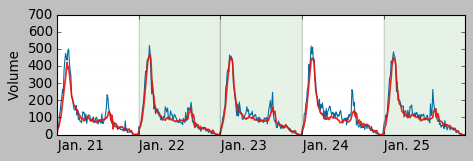

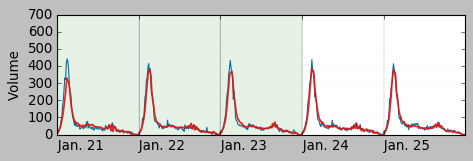

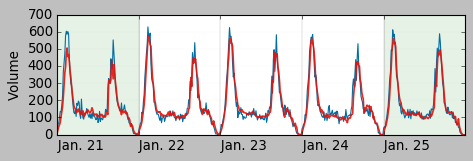

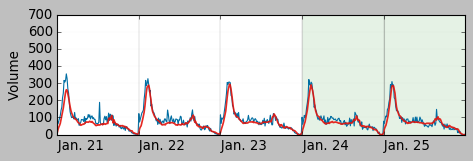

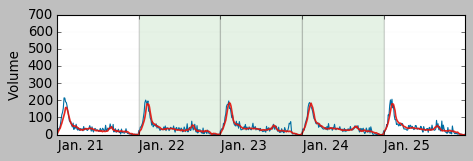

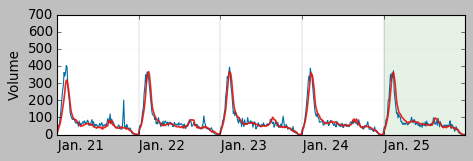

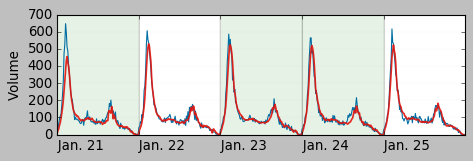

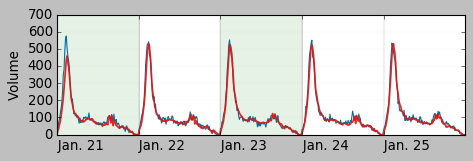

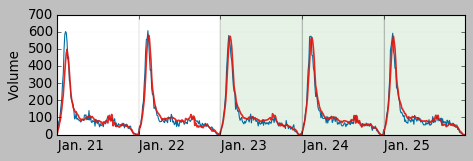

In [14]:
import matplotlib.pyplot as plt
import matplotlib.patches as patches


for i in range(station.shape[0]):
    plt.style.use('classic')
    fig = plt.figure(figsize=(6, 2))
    ax = fig.add_axes([0.12,0.15,0.85,0.75])
    plt.plot(data[3 * i, :], color = "#006ea3",linewidth = 1.0, label = "Actual value")
    plt.plot(data[3 * i + 2, :], color = "#e3120b", linewidth = 1.5, alpha = 0.9, label = "Predicted value")
    ax.set_xlim([0, pred_time_steps])
    ax.set_ylim([0, 700])
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.1, alpha = 0.2)
    for j in range(5):
        if data[3 * i + 1, 108 * j] > 0:
            someX, someY = j * 108, 0
            currentAxis = plt.gca()
            ax.add_patch(patches.Rectangle((someX, someY), 108, 700, alpha = 0.1, facecolor = 'green'))

    plt.xticks(np.arange(0, 5 * 108, 108), ["           Jan. 21", "           Jan. 22", 
                                          "           Jan. 23", "           Jan. 24", 
                                          "           Jan. 25"])
    ax.set_ylabel("Volume")
    ax.grid(color = 'gray', linestyle = '-', linewidth = 0.4, alpha = 0.5, axis = 'x')
    plt.show()
    fig.savefig("images/H_time_series_volume_{}.pdf".format(station[i] + 1))